In [1]:
# This is the final which should mirror the Kaggle notebook

# Climate Change Belief Analysis
#### by Team_SS4_JHB_First_Class on {date}

# Introduction 

# Table of Contents

1. Importing Libraries
2. Importing Dataset
3. Data Preprocessing
4. Exploratory Data Analysis
5. Feature Engineering and Selection
6. Model Selection 
7. Model Evaluation
8. References

# Importing Libraries

In [2]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nlppreprocess import NLP
from nltk import pos_tag
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing dataset

In [3]:
# Loading in the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

## Summary Statistics

In [4]:
# Looking at the first few entries in the dataset
train.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [5]:
# Shape of the dataset
train.shape

(15819, 3)

In [6]:
# dataframe information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
# Looking at the numbers of possible classes in our sentiment
train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [8]:
# Looking at the how the messages are distributed across the sentiment
train.describe()

sentiment        tweetid
count  15819.000000   15819.000000
mean       0.917504  501719.433656
std        0.836537  289045.983132
min       -1.000000       6.000000
25%        1.000000  253207.500000
50%        1.000000  502291.000000
75%        1.000000  753769.000000
max        2.000000  999888.000000

## Missing values

In [9]:
# Checking for missing values
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

Fortunately, there are no missing values in our dataset.

In [10]:
# Checking whether a character is white-space character or not
print(len(train['message']))
print(len(train['message'].apply(lambda x: x.isspace())))

15819
15819


In [11]:
# Sample tweet
tweet = train.iloc[6,1]
print(tweet)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


Text(0.5, 1.0, 'Distribution of target labels')

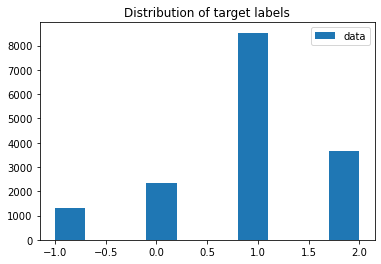

In [12]:
# Visualizing the distribution of the target 
plt.hist(train['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

It is notable that there is an imbalance of classes in the daset  and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This is can cause problems as most algorithms are designed to maximize accuracy and reduce error. Therefore we ill address and take care of the class imbalance in our EDA

Text(0, 0.5, 'Density')

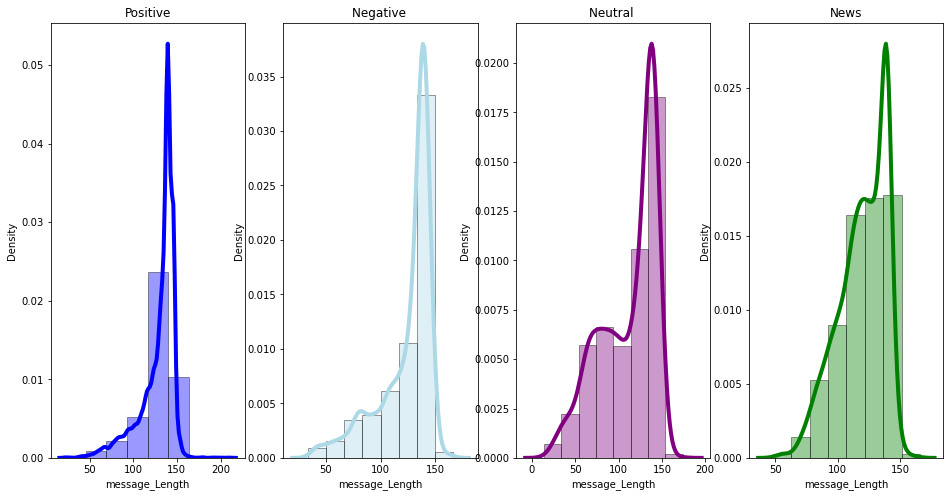

In [13]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(train[train['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train[train['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train[train['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(train[train['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

The average length of messages for all sentiments is not suprising as a tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting and will make for more unpacking later in the EDA.

# Exploratory Data Analysis

 We need to perform investigative and detective analysis of our data to see if we can unearth any insights. We appreciate the EDA stage the more we work on our text data. We have data being generated from tweets, digital media platforms, blogs, and a whole host of other sources. As a data scientists and an NLP enthusiasts, it’s important to analyze all this text data to help organizations make data-driven decisions.

In [14]:
working_df = train.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

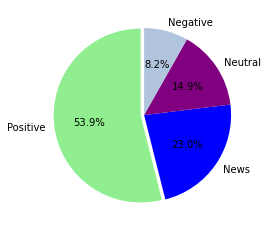

In [15]:
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['lightgreen', 'blue', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

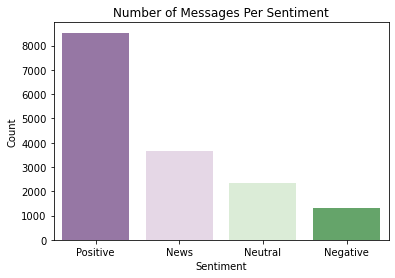

In [16]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

As we noted earlier that there is an imbalance of classes in the daset, this can lead to a disproportionate ratio of observations in each class, causing problems as most algorithms are designed to maximize accuracy and reduce error. We therefore continue to analyse and evaluate for more insights to be derived from the dataset as we prepared to balance later on in the analysis.

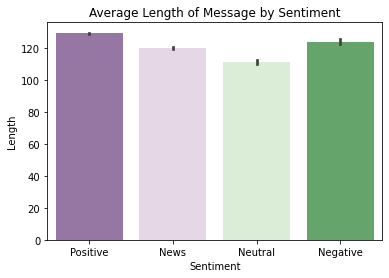

In [17]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

In [18]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in working_df.message]

In [19]:
# Generating Counts of users
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [20]:
# Top 5 most popular
counts.head()

users  message
3410  @StephenSchlegel      307
3270       @SenSanders      243
6182  @realDonaldTrump      143
448     @BernieSanders      121
612               @CNN      106

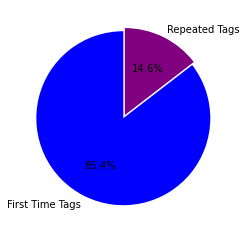

In [22]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['lightsteelblue', "purple"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

In [23]:
repeated_tags_rate = round(sum(np.array(counts['message']) > 1)*100/len(counts['message']), 1)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

14.6 percent of the data are from repeated tags


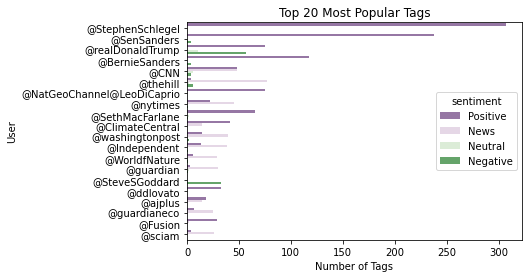

In [25]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df, palette='PRGn',
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

Now that we've had a look at the tweets themselves as well as the users, we now analyse the hastags:

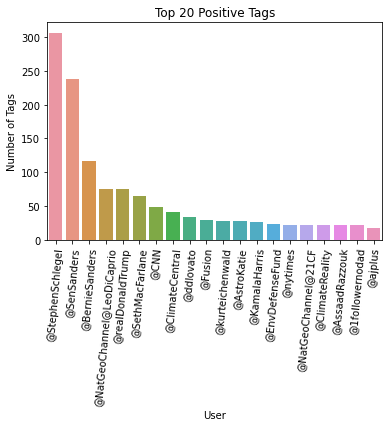

In [26]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Positive'],
              order=working_df[working_df['sentiment'] == 'Positive'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Positive Tags')
plt.xticks(rotation=85)
plt.show()

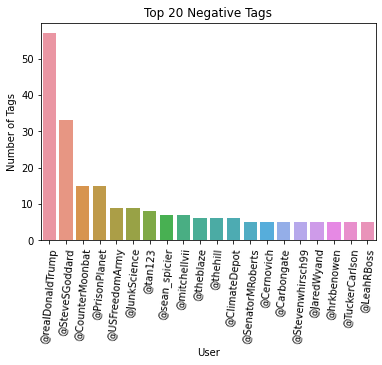

In [27]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

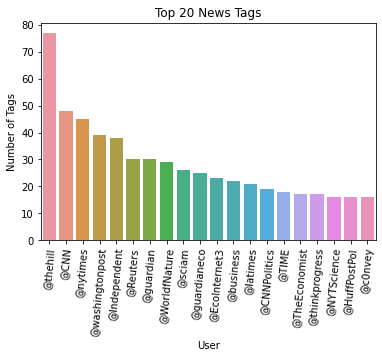

In [28]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'News'],
              order=working_df[working_df['sentiment'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

## Data Cleaning

Cleaning is the process of detecting and correcting corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data. We also apply database normalization which is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. Applying it will aslo help improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints. Stemming and Lemmatization are techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.



A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

In [29]:
# Testing the PorterStemmer 
stemmer = PorterStemmer()
print("The stemmed form of typing is: {}".format(stemmer.stem("typing")))
print("The stemmed form of types is: {}".format(stemmer.stem("types")))
print("The stemmed form of type is: {}".format(stemmer.stem("type")))

The stemmed form of typing is: type
The stemmed form of types is: type
The stemmed form of type is: type


In lemmatisation, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.

In [30]:
# Testing Lemmatization
lemm = WordNetLemmatizer()
print("In  case of Lemmatization, typing is: {}".format(lemm.lemmatize("typing")))
print("In  case of Lemmatization, types is: {}".format(lemm.lemmatize("types")))
print("In  case of Lemmatization, type is: {}".format(lemm.lemmatize("type")))

In  case of Lemmatization, typing is: typing
In  case of Lemmatization, types is: type
In  case of Lemmatization, type is: type


We will also need to also transform some of the messages into a more digestible form and keeping words and items that ar otherwise discarded. We will carry out this process using the nlp tool below.

In [31]:
pip install nlppreprocess

In [32]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('shouldnt')

'should not'

In [33]:
nlp.process('There is no good here')

'There no good'

The following function is an important step in the data mining process. In our case of classification, preprocessing data means; Data cleaning, Fill in missing values, smoothing noisy data and resolving any existing inconsistencies. Success in the steps will then make it possible and some-what easy for us to perform Data integration, Data transformation, Normalization and aggregation as well as Data reduction.

In [34]:
# Data cleaning for furthur sentiment analysis

def cleaner(line):
    '''
    For preprocessing the data, we regularize, transform each upper case into lower case, tokenize,
    normalize and remove stopwords. Normalization transforms a token to its root word i.e. 
    These words would be transformed from "love loving loved" to "love love love."
    
    '''
    
    # print("Original:\n", line, '\n'*2)

    # Removes RT, url and trailing white spaces
    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) 
    # print("After removing RT, url and trailing white spaces:\n" + line, '\n'*2)

    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # removes emoticons,
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    line = emojis.sub(r'', line)

    # Removes puctuation
    punctuation = re.compile("[.;:!\'’‘“”?,\"()\[\]]")
    tweet = punctuation.sub("", line.lower()) 
    # print("After puctuation:\n", tweet, '\n'*2)

    # Removes stopwords
    nlp_for_stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    tweet = nlp_for_stopwords.process(tweet) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52
    # print("After removing stopwords:\n", tweet, '\n'*2)

    # tokenisation
    # We used the split method instead of the word_tokenise library because our tweet is already clean at this point
    # and the twitter data is not complicated
    tweet = tweet.split() 
    # print("After tokenisation:\n", tweet, '\n'*2)

    # POS 
    pos = pos_tag(tweet)
    # print("After POS:\n", pos, '\n'*2)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = ' '.join([lemmatizer.lemmatize(word, po[0].lower()) 
                      if (po[0].lower() in ['n', 'r', 'v', 'a'] and word[0] != '@') else word for word, po in pos])
    # print("After Lemmatization:\n", tweet, '\n'*2)

    return tweet

In [35]:
text1 = cleaner(tweet)
print('BEFORE')
print(tweet, '\n'*2)
print('AFTER')
print(text1)
# In the tweet below, you can see that "not" was added and kept, because the word is significant

BEFORE
RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R 


AFTER
@thenation mike penny not believe in global warming smoking cause lung cancer


In [40]:
cleaned = train['message'].apply(cleaner)

In [41]:
cleaned.head()

0    polyscimajor epa chief not think carbon dioxid...
1    its not like we lack evidence anthropogenic gl...
2    @rawstory researcher say we three year act cli...
3    #todayinmaker# wire pivotal year in war climat...
4    @soynoviodetodas its and racist sexist climate...
Name: message, dtype: object

In [42]:
working_df['clean'] = cleaned

The summarising investigative and detective analysis of our data to see if we can unearth any insights includes wordclouds. Outputs from such analyses can be used in different digital media platforms, blogs, and a whole host of other online sources. As such, they can easily help organizations make data-driven decisions without having to decode too much technical terms.

In [43]:
# Combining all the messages
text_before_cleaning = " ".join(tweet for tweet in train['message'])
text_after_cleaning = " ".join(tweet for tweet in cleaned)
# print ("There are {} characters in the combination of all tweets.".format(len(text)))

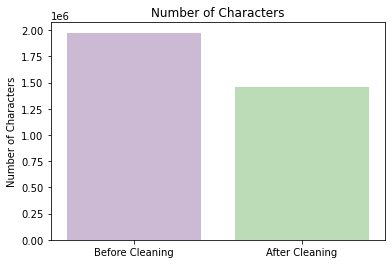

In [45]:
# Numbers of characters
sns.barplot(x=['Before Cleaning', 'After Cleaning'], y=[len(text_before_cleaning), len(text_after_cleaning)], palette='PRGn')
# sns.countplot(x=[] ,data = working_df, palette='PRGn')
plt.ylabel('Number of Characters')
# plt.xlabel('Sentiment')
plt.title('Number of Characters')
plt.show()

In [46]:
# Combining all the messages
text = " ".join(tweet for tweet in working_df.message)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 1976222 words in the combination of all tweets.


Word clouds are a simple visualization of data, in which words are shown in varying sizes depending on how often they appear. The kind of insight they provide even without much analysis being done helps in data normalization and in also what to expect as we dive deeper into data analysis. In our case, it is no surprise that both "climate change" and "global warming" as the biggest words in the could. Some other big words include "https" and "RT" which can be easily categorized as potential stopwords.

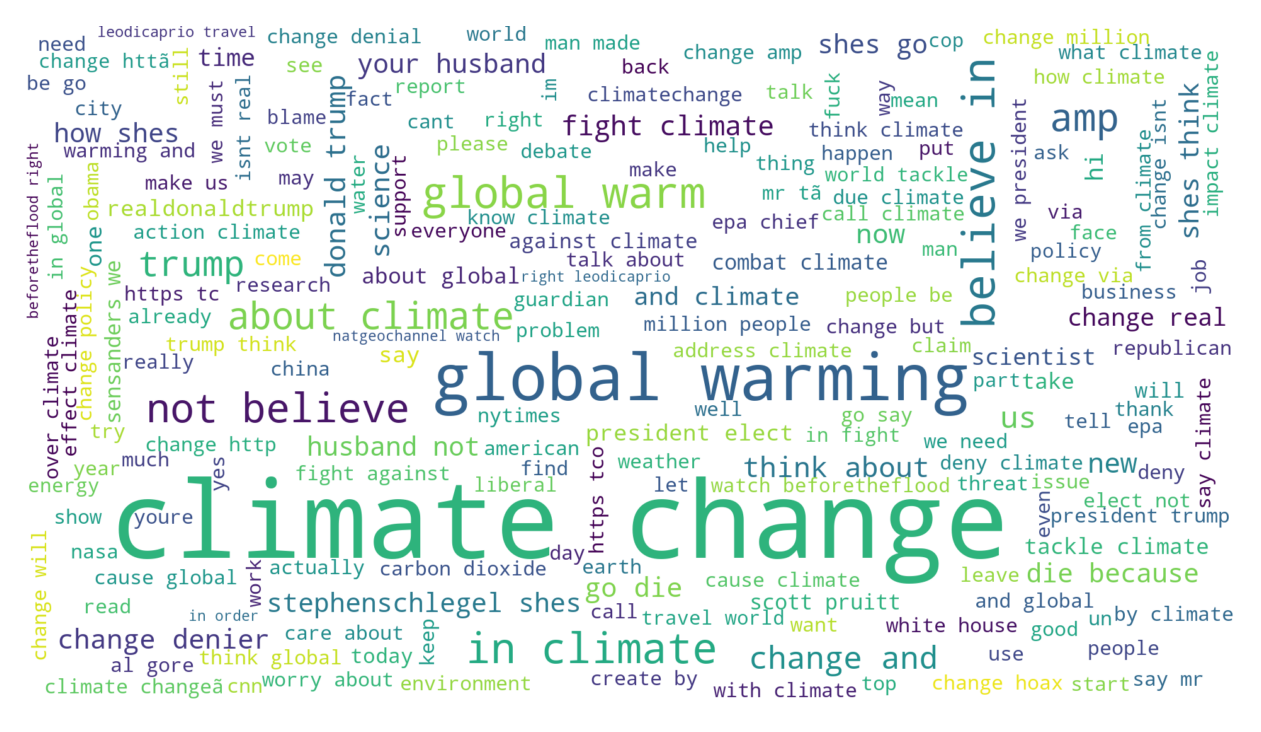

In [47]:
# Generating the word cloud image from all the messages
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(text_after_cleaning)

# Displaying the word cloud image:
# using matplotlib way:
# plt.title("General Word Cloud")
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

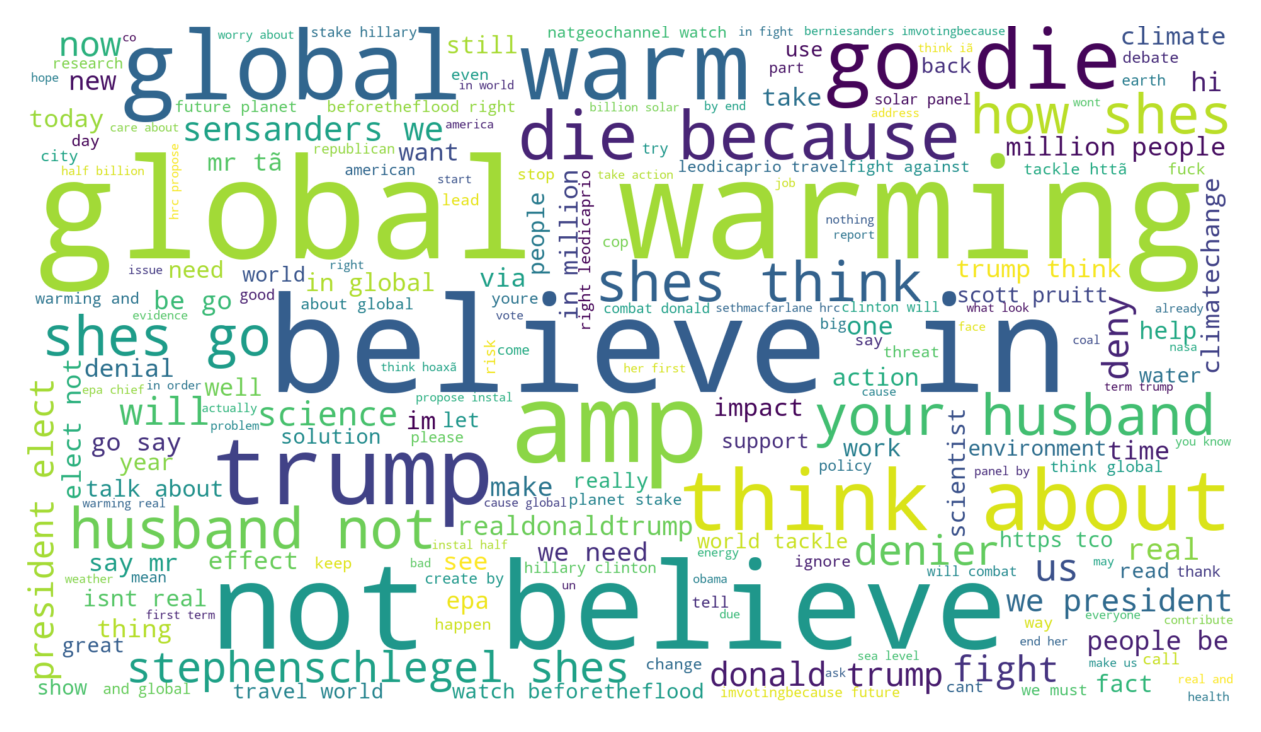

In [48]:
# Wordcloud for the cleaned data:Positive sentiment
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['clean'][working_df['sentiment'] == 'Positive']))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud using matplotlib:
# plt.title("General Word Cloud")
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

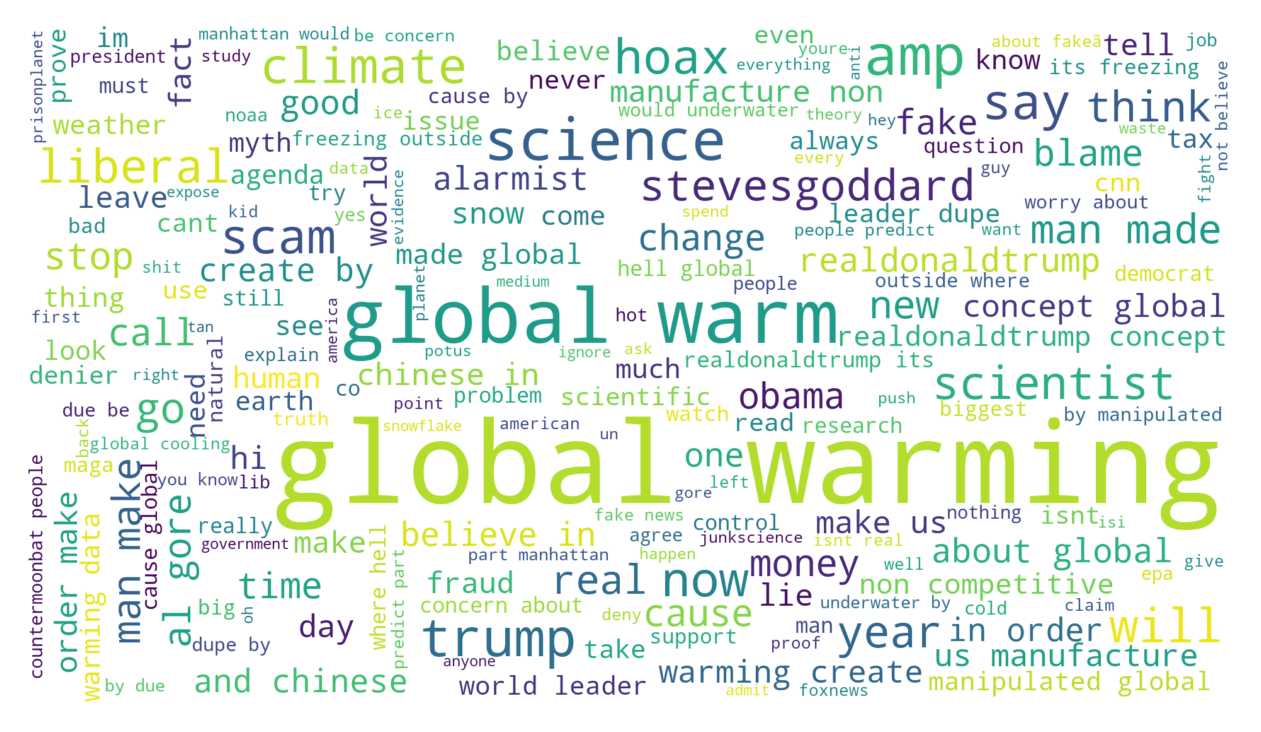

In [49]:
# Wordcloud for the cleaned data:Negative sentiment
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['clean'][working_df['sentiment'] == 'Negative']))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud image:
# plt.title("General Word Cloud")
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

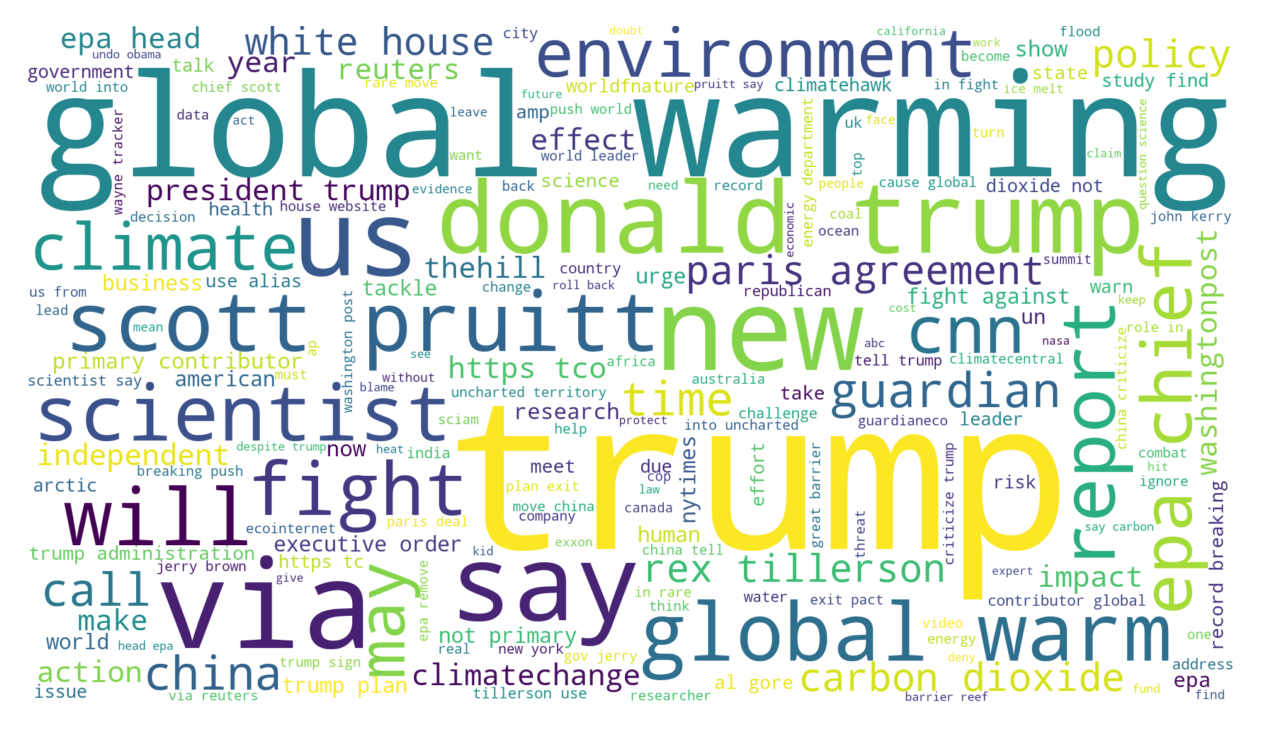

In [50]:
# Wordcloud for the cleaned data:News
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['clean'][working_df['sentiment'] == 'News']))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud image:
# plt.title("General Word Cloud")
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Moving on, we look at the different hashtags that come with each tweet:

In [51]:
# Creating a column of hastags
working_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in working_df.message]

In [52]:
# A sneak peak of these tweets plus hashtags
working_df.head()

sentiment                                            message  tweetid  \
0  Positive  PolySciMajor EPA chief doesn't think carbon di...   625221   
1  Positive  It's not like we lack evidence of anthropogeni...   126103   
2      News  RT @RawStory: Researchers say we have three ye...   698562   
3  Positive  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4  Positive  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

              users                                              clean  \
0         @mashable  polyscimajor epa chief not think carbon dioxid...   
1               NaN  its not like we lack evidence anthropogenic gl...   
2         @RawStory  @rawstory researcher say we three year act cli...   
3               NaN  #todayinmaker# wire pivotal year in war climat...   
4  @SoyNovioDeTodas  @soynoviodetodas its and racist sexist climate...   

          hashtags  
0              NaN  
1              NaN  
2              NaN  
3  #TodayinMaker #  
4   #ElectionNight

A visual represenation of the hashtags using word clouds

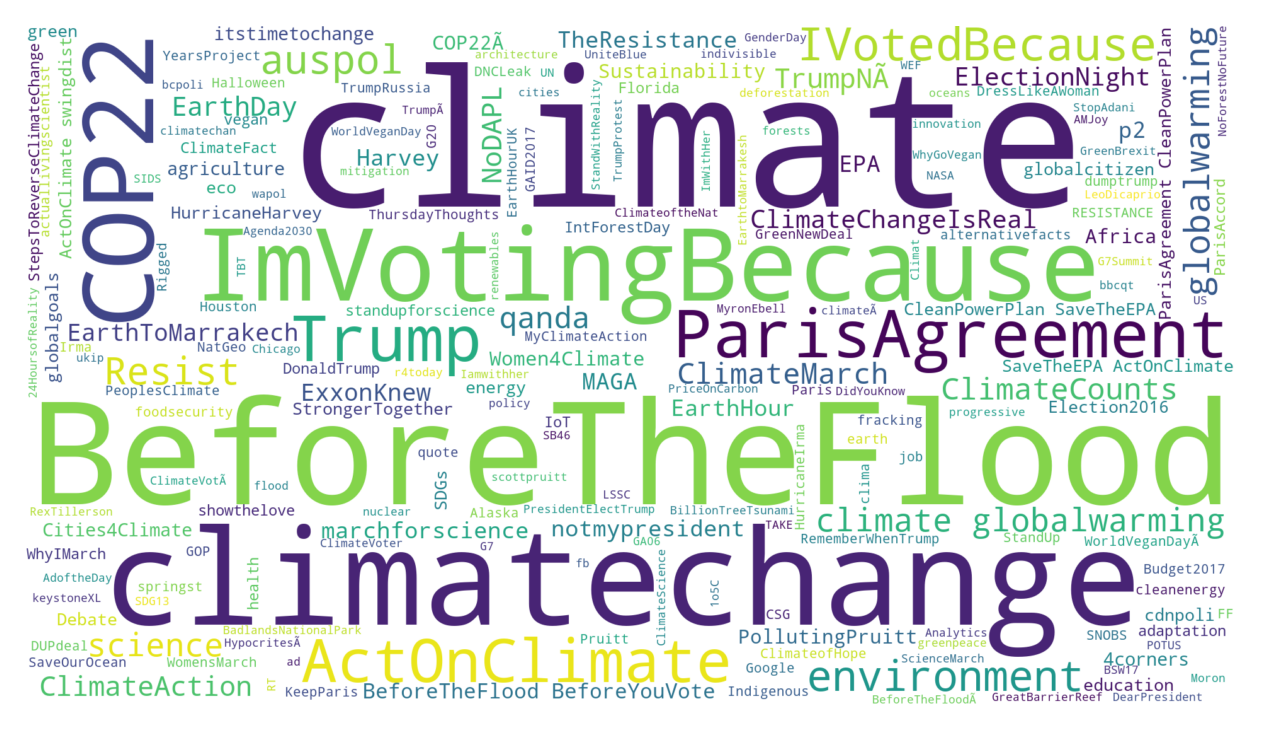

In [53]:
# Creating a wordcloud of the hashtags: Positive sentiment
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['hashtags'][working_df['sentiment'] == 'Positive'] if type(tweet) == str))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud image:
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

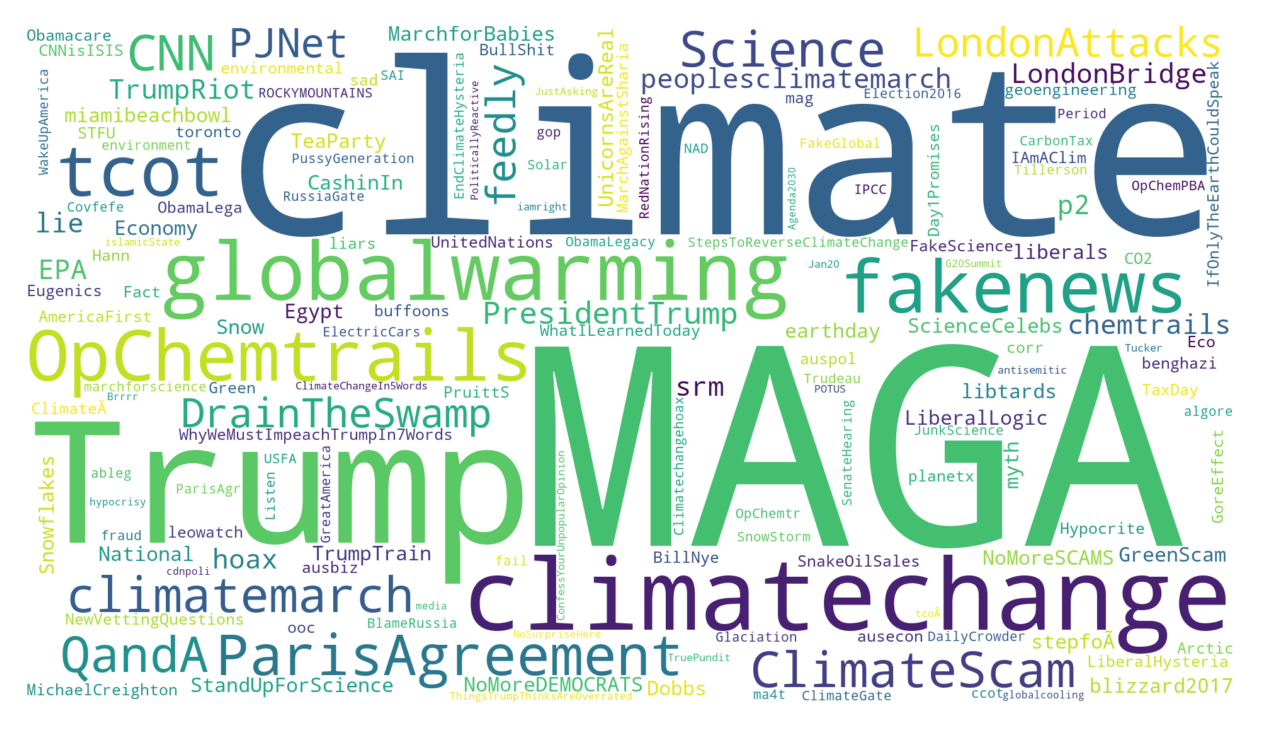

In [54]:
# Wordcloud for the hashtags:Negtive sentiment
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['hashtags'][working_df['sentiment'] == 'Negative'] if type(tweet) == str))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud image:
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

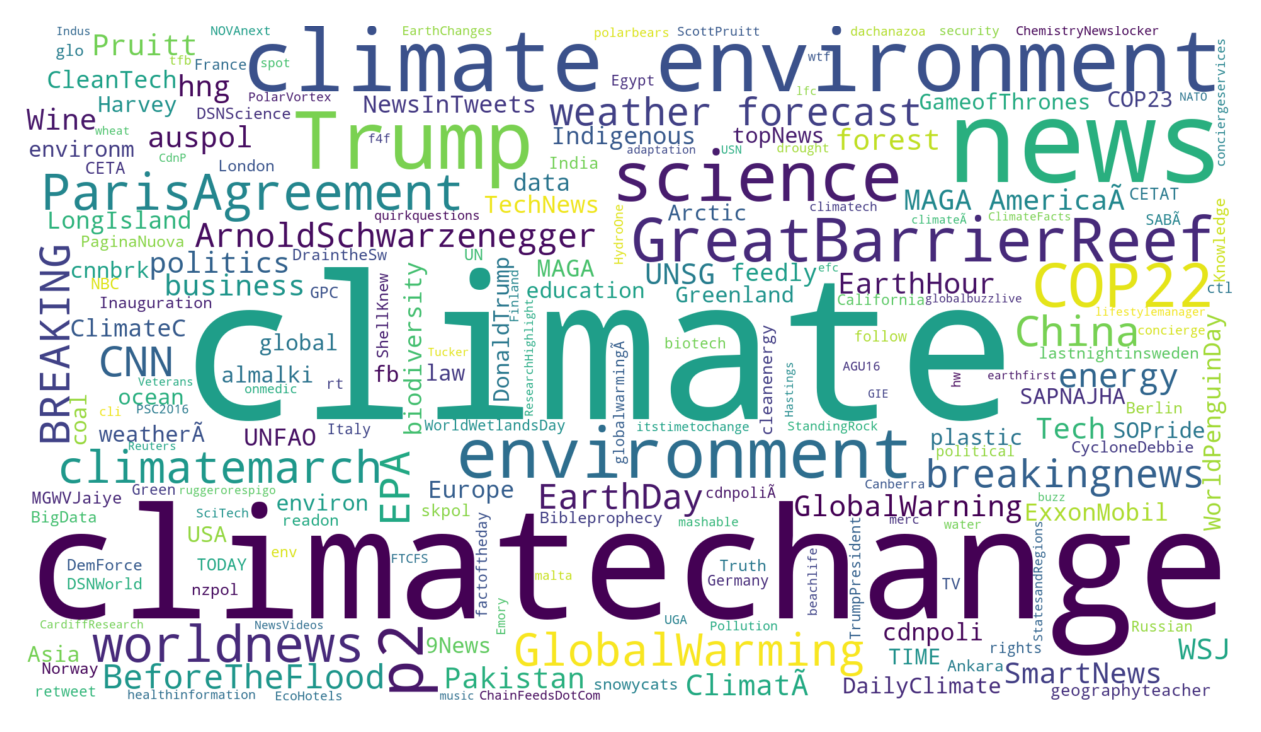

In [55]:
# Wordcloud for the hashtags:News
corpus = re.sub("climate change", ''," ".join(tweet.strip() for tweet in working_df['hashtags'][working_df['sentiment'] == 'News'] if type(tweet) == str))
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white",
                      width = 1920, height = 1080, colormap="viridis").generate(corpus)

# Displaying the word cloud image:
# plt.title("General Word Cloud")
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature Engineering and Selection

#### Feature Extraction

For our *Feature Extraction*, we use CV and TF-IDF. These are tools which will help encode the words as integers or floating point values for use as input to a machine learning algorithm.

CountVectorizer counts the word frequencies, while the TFIDFVectorizer (The term frequency-inverse document frequency) is a weight whose value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus. The TF-IDF weight is a weight often used in information retrieval and text mining. Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.

In [73]:
# Converting the collection of clean messages to a matrix of token counts
corpus = working_df['clean']

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())
#print(X.toarray())

In [71]:
# Converting the collection of clean messages to a matrix of TF-IDF features
data = working_df['clean']

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
vectorized = vectorizer.fit_transform(data)
#print(vectorizer.get_feature_names())
#print(X.toarray())

In some problems the countsvec is better suited for model training in others the tfidf representation is the best choice. We have decided to try them both. Although the two representations are very similar and therefore carry approximately the same information, it could be the case that you will get better precision by using the full set of features(tfidf+counts).

In [74]:
# Using sparse to train the model using both representations.
import scipy.sparse

# Defining the features as well as the label
X = scipy.sparse.hstack([vectorized, count_vectorized])
y = working_df['sentiment']

# Model Selection

Below we import some of the models that we will be training:

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn import metrics

## Training with imbalanced data

In [76]:
from sklearn.model_selection import train_test_split

# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [77]:
# Creating a list of all the models to train
algs = [LogisticRegression(random_state = 5), SVC(kernel = 'linear', random_state = 5), SVC(kernel = 'rbf', random_state = 5)
        ,MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=6),RandomForestClassifier()]

In [81]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([('clf', algs[i])])
    ##lowercase = True,stop_words='english', ngram_range=(1, 2), analyzer='word',max_df = 0.8
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)
    
    
    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[ 192   58   23  155]
 [  37  333   69  298]
 [   3   26  912  254]
 [  44  189  231 2397]]
              precision    recall  f1-score   support

    Negative       0.70      0.45      0.55       428
     Neutral       0.55      0.45      0.50       737
        News       0.74      0.76      0.75      1195
    Positive       0.77      0.84      0.80      2861

    accuracy                           0.73      5221
   macro avg       0.69      0.63      0.65      5221
weighted avg       0.73      0.73      0.73      5221

F1_score:  0.727
-------------------------------------------------------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
 

##### Best perfoming models

-LogisticRegression()

-SVC()

### Balancing the classes

#### Class size to up/down sample

Resampling is a process which involves changing the frequency of the observations. Below we apply it to assess whether or not it will improve our training. 

In [ ]:
# importing the module and creating a resampling variable
from sklearn.utils import resample
data = train.copy()
class_size = int(len(data[data['sentiment']==1])/2)

In [112]:
# seperating the four classes
class_1 = data[data['sentiment']==-1]
class_2 = data[data['sentiment']==0]
class_3 = data[data['sentiment']==1]
class_4 = data[data['sentiment']==2]

#### Up-sampling

 Here we increase the frequency of the samples.

In [113]:
# upsampling classes 1, 2, and 4 & downsampling class 3
class_1_up = resample(class_1,replace=True,n_samples=class_size, random_state=27)
class_2_up = resample(class_2,replace=True,n_samples=class_size, random_state=27)
class_4_up = resample(class_4,replace=True,n_samples=class_size, random_state=27)
class_3_down = resample(class_3,replace=False,n_samples=class_size, random_state=27)

In [120]:
# Creating a new DataFrame out of the balanced bata
res_df = pd.concat([class_1_up, class_2_up, class_4_up,class_3_down])

TypeError: can only concatenate str (not "float") to str

In [110]:
# Checking if data has been well-balanced
sns.countplot(x = res_df['sentiment'], data = data)
plt.show()

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

The equal distribution of classes as shown on the count plot, confirms that classes are now balanced.

## Training with balanced data

In [101]:
# Defining the features as well as the label 
X_res = res_df['message']
y_res = res_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [47]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([('clf', algs[i])])
   
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)
    
    
    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

NameError: name 'X_train' is not defined

##### Best perfoming models

-LogisticRegression()
-SVC()
-MultinomialNB()
-RandomForestClassifier()

#### Changing the algorithm

Since we fitted ~5 models from the get go, changing the algorithm to fit with our data is hafway done hence we opted to create a Long Short-Term Memory (LSTM) recurrent neural network to classify our tweets to see how it performs compared to the other models

# Model Evaluation

Accuracy is not always the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:

1. Confusion Matrix: table shows correct predictions and types of incorrect predictions.
2. Precision: the number of true positives divided by all positive predictions. 
3. Recall: the number of true positives divided by the number of positive values in the test data. 
4. F1: Score: the weighted average of precision and recall.

In [48]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

NameError: name 'y_test' is not defined

This is then fllowed by a Classification report which is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as shown below.

In [49]:
print(metrics.classification_report(y_test, y_pred))

NameError: name 'y_test' is not defined

# References

In [ ]:
Reccurent Neural Networks (RNN), the following video from MIT is an excellent resource:
    https://www.youtube.com/watch?v=SEnXr6v2ifU